# MLP Univariate

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from keras.activations import sigmoid
from keras.models import Sequential
from keras import models, layers, backend, optimizers
from keras.layers import Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
import time
from math import sqrt

/var/folders/_h/_mbf393j6vn3d57lvxzw185c0000gn/T/ipykernel_49785/3190480299.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-07-06 21:42:27.418991: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
# we read our dataframe and assign the time column as the index values of the dataframe
file = "./dataset.csv"
df = pd.read_csv(file, index_col='Date', parse_dates=True)
df.head()

,AUD,EUR,NZD,GBP,BRL,CAD,CNY,DKK,HKD,INR,...,CHF,TWD,THB,VEB,gdpGBP,gdpUSD,GBR_Value,USA_Value,liborUSD,liborGBP
Date,,,,,,,,,,,,,,,,,,,,,
2000-02-01,0.6315,0.9731,0.4904,1.6150,1.795,1.4468,8.2774,7.6445,7.7807,43.62,...,1.6540,31.75,37.51,0.6563,100.9050,101.5818,NaN,NaN,5.84138,5.97114
2000-03-01,0.6067,0.9700,0.4853,1.5849,1.769,1.4470,8.2786,7.6730,7.7824,43.63,...,1.6568,30.75,38.11,0.6630,100.9352,101.6581,NaN,NaN,5.96000,5.88913
2000-05-01,0.5800,0.9120,0.4835,1.5558,1.807,1.4783,8.2799,8.1695,7.7890,43.67,...,1.7135,30.65,38.12,0.6758,100.9194,101.7747,NaN,NaN,6.43857,5.99906
2000-06-01,0.5721,0.9307,0.4561,1.4915,1.821,1.4910,8.2771,8.0225,7.7920,44.65,...,1.6878,30.90,39.19,0.6818,100.8875,101.7674,NaN,NaN,6.66582,5.99415
2000-08-01,0.5805,0.9228,0.4546,1.4992,1.786,1.4892,8.2788,8.0840,7.7993,45.15,...,1.6758,31.15,41.09,0.6880,100.8101,101.6210,NaN,NaN,6.57688,5.94362


In [13]:
def CreateLaggedSequence(data, lag):
    # make two lists for PredictorSequences and ResponseVariables
    PredictorSequences, ResponseVariables = list(), list()
    for i in range(len(data)):
        # mark the range of the sequence
        end_i = i + lag
        # check when the data ends
        if end_i+1 > len(data):
            # stop sequence creation
            break
        # get the predictors and responses
        PredictorSequence = data[i:end_i]
        ResponseVariable = data[end_i]
        # append them to the lists
        PredictorSequences.append(PredictorSequence)
        ResponseVariables.append(ResponseVariable)
        # print(end_i)
    return np.array(PredictorSequences), np.array(ResponseVariables)

In [14]:
# Get the univariate series
X = df['GBP']
np_X = np.array(X)
# Create the lagged values for the series (50 lags)
X, y = CreateLaggedSequence(np_X, 50)
lag = X.shape[1]
# Reshape it for the process
X = X.reshape(X.shape[0], X.shape[1]) 
X.shape, y.shape, len(X), len(y)

((153, 50), (153,), 153, 153)

In [15]:
# split the train and test sets (last 50 observation spared for the test)
x_train, x_test = X[:-50], X[-50:]
y_train, y_test = y[:-50], y[-50:]
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((103, 50), (50, 50), (103,), (50,))

In [16]:
# Define a new activation function
# Nerds, R. (2018, August 19). Swish Activation Function by Google. Retrieved from https://medium.com/@neuralnets/swish-activation-function-by-google-53e1ea86f820

def swish(x, beta = 1):
    return (x * sigmoid(beta * x))

from keras.utils import get_custom_objects
from keras.layers import Activation
get_custom_objects().update({'swish': Activation(swish)})

In [17]:
# create a start point for timer
start = time.time()

# design the model
backend.clear_session()
model = models.Sequential()

model.add(layers.Dense(3*2**8, activation = 'swish', kernel_initializer='he_uniform', input_shape = (x_train.shape[1],)))
model.add(layers.Dense(3*2**6, activation='swish', kernel_initializer='he_uniform'))
model.add(layers.Dense(3*2**7, activation='swish', kernel_initializer='he_uniform'))
model.add(layers.Dense(3*2**5, activation='swish', kernel_initializer='he_uniform'))
model.add(layers.Dense(3*2**6, activation='swish', kernel_initializer='he_uniform'))
model.add(layers.Dense(3*2**4, activation='swish', kernel_initializer='he_uniform'))
model.add(layers.Dense(3*2**5, activation='swish', kernel_initializer='he_uniform'))
model.add(layers.Dense(3*2**3, activation='swish', kernel_initializer='he_uniform'))
model.add(layers.Dense(3*2**4, activation='swish', kernel_initializer='he_uniform'))
model.add(layers.Dense(3*2**2, activation='swish', kernel_initializer='he_uniform'))
model.add(layers.Dense(3*2**3, activation='swish', kernel_initializer='he_uniform'))
model.add(layers.Dense(3*2**1, activation='swish', kernel_initializer='he_uniform'))
model.add(layers.Dense(3*2**2, activation='swish', kernel_initializer='he_uniform'))
model.add(layers.Dense(3*2**0, activation=tf.keras.backend.sin, kernel_initializer='he_uniform'))
model.add(layers.Dense(3*2**1, activation='swish', kernel_initializer='he_uniform'))

model.add(layers.Dense(1, activation='swish'))
# compile the model
model.compile(optimizer = optimizers.Adam(learning_rate=0.00011), loss = 'mse', metrics = ['mae'])
#get the summary of the model
model.summary()

################################################################################

# fit the model
history = model.fit(x_train, y_train, 
            epochs = 2**10, 
            batch_size = 3856, 
            validation_split = 0.20, # sparing validation data from the training data
            verbose = 1, 
            callbacks=[EarlyStopping(monitor='val_mae', patience=2**9,)])

#evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print('test_acc:', test_acc)

# end the timer and print the total time passed
end = time.time()
print("Total time:", end-start, "seconds")

/Users/tranphuctho276/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 768)            │        39,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 192)            │       147,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 384)            │        74,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 96)             │        36,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 192)            │        18,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 48)             │         9,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 96)             │         4,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 24)             │         2,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 48)             │         1,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 12)             │           588 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 24)             │           312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │           150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 12)             │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │            39 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 6)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 335,212 (1.28 MB)

 Trainable params: 335,212 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1024
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 2.1717 - mae: 1.4622 - val_loss: 1.1607 - val_mae: 1.0765
Epoch 2/1024
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 2.5737 - mae: 1.5851 - val_loss: 1.2513 - val_mae: 1.1169
Epoch 3/1024
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.9741 - mae: 1.3845 - val_loss: 0.9660 - val_mae: 0.9777
Epoch 4/1024
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 1.3571 - mae: 1.1267 - val_loss: 1.1243 - val_mae: 1.0568
Epoch 5/1024
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.9477 - mae: 0.9541 - val_loss: 1.3706 - val_mae: 1.1698
Epoch 6/1024
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.0299 - mae: 1.0006 - val_loss: 1.3562 - val_mae: 1.1637
Epoch 7/1024
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.9231 - mae: 0.9444 - val_loss: 1.1558 - val_mae: 1.0734
Epoch 8/1024
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.6256 - mae: 0.7731 - val_loss: 0.7902 - val_mae: 0.8843
Epoch 9/1024
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.5812 

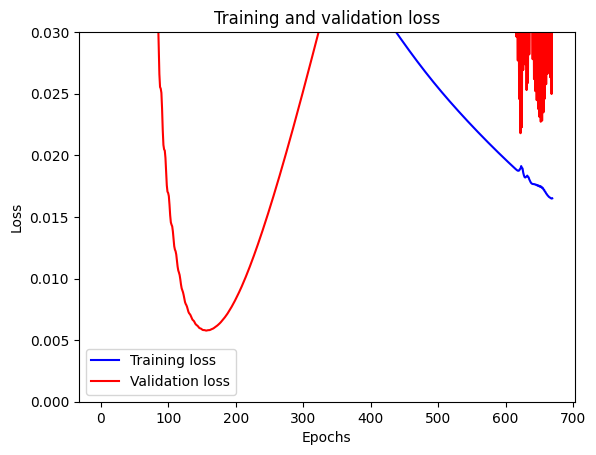

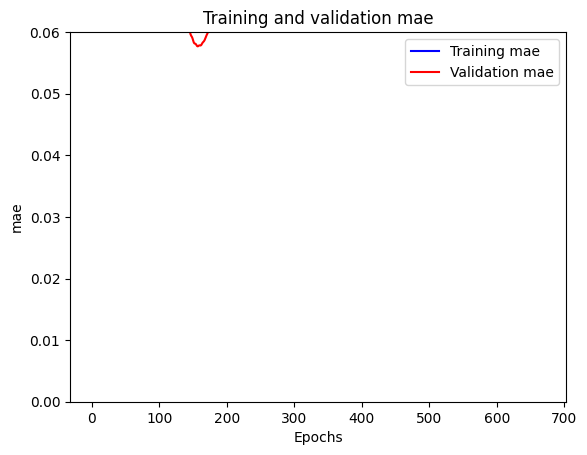

In [18]:
# get the history of the fitting process
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
mae_values = history_dict['mae']
val_mae_values = history_dict['val_mae']
epochs = range(1, len(history_dict['mae']) + 1)
# plot the training and validation losses
plt.plot(epochs, loss_values, label = 'Training loss', color='blue')
plt.plot(epochs, val_loss_values, label = 'Validation loss', color='red')
plt.ylim(0,0.03)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
# plot the training and validation mae (mean absolute error)
plt.plot(epochs, mae_values, label = 'Training mae', color='blue')
plt.plot(epochs, val_mae_values, label = 'Validation mae', color='red')
plt.ylim(0,0.06)
plt.title('Training and validation mae')
plt.xlabel('Epochs')
plt.ylabel('mae')
plt.legend()
plt.show()

In [19]:
# predict the model on the test set
yhat = model.predict(x_test, verbose=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


In [20]:
# convert the predictions series
predictions = pd.Series(yhat.reshape((50)), index=df['GBP'].index[-50:])
# extract the actual values
actuals = df['GBP'][-50:]

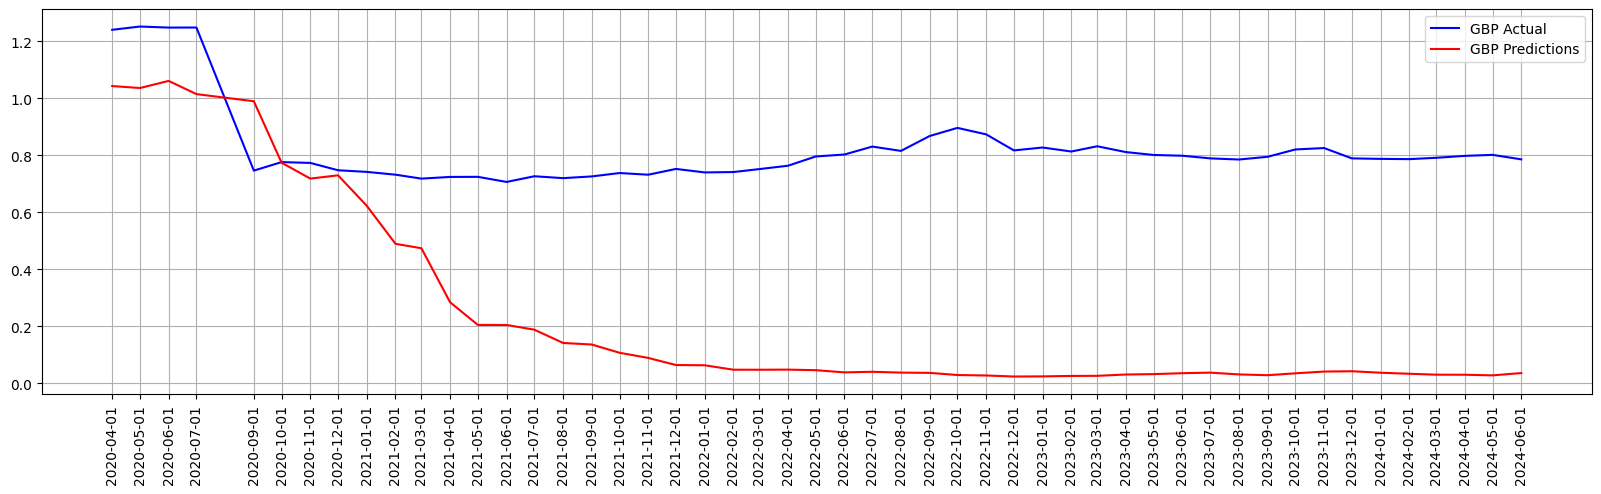

Test RMSE: 0.64966


In [21]:
# evaluate forecasts and plot them together
plt.figure(figsize=(20,5))
plt.plot(actuals.index, actuals, color='blue')
plt.plot(actuals.index, predictions, color='red')
plt.legend(('GBP Actual', 'GBP Predictions'))
plt.xticks(actuals.index, rotation=90)
plt.grid(True)
plt.show()

rmse = sqrt(mean_squared_error(actuals, predictions))
print('Test RMSE: %.5f' % rmse)